# Table of Contents
* [load data](#load-data)
* [process data](#process-data)
	* [bonuses](#bonuses)
	* [frame build](#frame-build)
	* [analysis](#analysis)
	* [building frames](#building-frames)
* [bounding box clustering](#bounding-box-clustering)
* [bonus cost estimate](#bonus-cost-estimate)
* [HTML Review](#HTML-Review)
* [hide](#hide)


In [2]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
import warnings
warnings.filterwarnings('ignore')

# load data

In [733]:
data_paths = ['./pickeled_results/turker_batch_{}.pkl'.format(i) for i in range(1,6)]

turk_data_assemble = [unpickle_this(data_path) for data_path in data_paths]
batch_8 = unpickle_this('./pickeled_results/turker_batch_8.pkl')

turk_data = {}
_ = [turk_data.update(data_part) for data_part in turk_data_assemble + [batch_8]]

batch_2 = turk_data_assemble[0]
batch_2 = turk_data_assemble[1]
batch_3 = turk_data_assemble[2]
batch_4 = turk_data_assemble[3]
batch_5 = turk_data_assemble[4]

# all_so_far = unpickle_this('./pickeled_results/turker_all_subtask_8_12.pkl')

In [741]:
prod_batch_1_4 = unpickle_this('./pickeled_results/prod_batch_1_4.pkl')

In [742]:
len(prod_batch_1_4)

20000

In [324]:
with open('complete_clips.txt', 'r') as f:
    clips_completed_raw = f.read()

clips_completed = set(clips_completed_raw.split())

In [331]:
with open('./complete_subtask_clips.txt', 'r') as f:
    subtask_complete = f.read()

subtask_complete = set(subtask_complete.split())

# process data

In [56]:
main_characters =  {"fred",
             "barney",
              "wilma",
              "betty",
              "pebbles",
              "bamm bamm",
              "dino",
              "mr slate",
              "baby puss",
              "hoppy",
              "empty frame",
              "no characters"}

def create_result(assmt):
    result = json.loads(assmt.answers[0][0].fields[0])
    result['h_id'] = assmt.HITId
    result['worker_id'] = assmt.WorkerId
    return result


def all_main(char_set, main_chars=main_characters):
    return not bool(char_set.difference(main_chars))

In [439]:
len(batch_8)

1632

In [743]:
assignments =[]
for assignment_triple in list(prod_batch_1_4.values()):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]
characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

In [744]:
len(assignments)

59836

## build frames

In [745]:
annotations_by_frame = defaultdict(list)
for anno in sorted(assignment_results, key=lambda x: x['stillID']):
    animation_id = anno['stillID'].rsplit('_', 1)[0]
    annotations_by_frame[animation_id].append(anno)

In [442]:
# with open('complete_clips.txt', 'a') as f:
#     import csv
#     cw = csv.writer(f, delimiter=' ')
#     cw.writerow(list(annotations_by_frame.keys()))

# bonuses

In [397]:
reject_variations = {
    "otherchar",
    "0ther",
    "schwenk",
}

In [746]:
def filter_rejects(chars):
    genuine_bonus = []
    reject = []
    for char in chars:
        comp_string = ''.join(c for c in char if c.isalnum()).lower()
        reject_chars = [char for var in reject_variations if var in char.replace(' ','')]
        if reject_chars or len(char.replace(' ','')) < 3:
            reject.extend(reject_chars)
        else:
            genuine_bonus.append(char)
    return reject, genuine_bonus

def assign_bonuses(assignments):
    bonuses = {}
    rejections = {}
    worker_lookup = {}
    all_descriptions = []
    for asgmt in assignments:
        aid = asgmt.AssignmentId
        worker_id = asgmt.WorkerId
        worker_lookup[aid] = worker_id
        result = create_result(asgmt)
        all_descriptions.extend([char['label'] for char in json.loads(result['characterBoxes'])])
        bonus_chars = [char['label'] for char in json.loads(result['characterBoxes']) if char['label'] not in main_characters]
        rejects, bonus_chars = filter_rejects(bonus_chars)
        if rejects:
            rejections[aid] = (rejects, bonus_chars)
        elif bonus_chars:
            bonuses[aid] = len(bonus_chars)
#             bonuses[aid] = bonus_chars
    return bonuses, rejections, worker_lookup, all_descriptions

In [750]:
worker_counts = pd.Series(list(asgmt_workers.values())).value_counts()

In [751]:
sum(worker_counts > 50)

248

In [747]:
bonuses, to_reject, asgmt_workers, all_descriptions = assign_bonuses(assignments)

In [748]:
len(assignments)

59836

In [752]:
all_rejections = []
for chars in to_reject.values():
    all_rejections.extend(chars[0])

In [753]:
pd.Series(list(bonuses.values())).sum() * 0.01

151.53999999999999

In [379]:
# pickle_this(bad_aids, 'to_reject.pkl')

In [380]:
# pd.Series(all_rejections).value_counts()

In [754]:
bad_aids = set(to_reject.keys())

In [756]:
bad_workers = set([asgmt_workers[aid] for aid in bad_aids])
len(bad_workers)

bad_workers

{'A1HL8LE2075V80', 'A1WHEV7QAX73IC'}

In [757]:
worker_bonuses = defaultdict(int)
for aid, char_count in bonuses.items():
    worker_bonuses[aid] = {
        'count': char_count,
        'worker_id': asgmt_workers[aid]
    }

In [758]:
len(worker_bonuses)

10819

In [384]:
bonuses_payed = unpickle_this('pickeled_results/bonuses_to_pay_2.pkl')

In [365]:
len(bonuses_payed)

2187

In [413]:
pickle_this(worker_bonuses, 'bonuses_to_pay_3.pkl')

# analysis

## flaw finding

In [686]:
from amt_utils.flintstones import display_image

In [687]:
results_by_still = defaultdict(dict)
for anno in characters_present:
    results_by_still[anno['still_id']][anno['w_id']] = anno
results_by_still = dict(results_by_still)

In [688]:
worker_flaws = {
    'self_inconsistent_empty_frame' : [],
    'disagree_on_empty': []
}


for still, still_annos in results_by_still.items():
    char_sets = {w_anno['w_id']: w_anno['characters'] for w_anno in still_annos.values()}
    all_chars = set()
    _ = [all_chars.update(char_set) for char_set in char_sets.values()]
    for wid, char_set in char_sets.items():
        if 'empty frame' in char_set:
            if len(char_set) > 1:
                worker_flaws['self_inconsistent_empty_frame'].append({wid: still})
            elif len({owid:chars for owid, chars in char_sets.items() if (owid != wid and chars.difference({'empty frame'}))}) > 1:
                worker_flaws['disagree_on_empty'].append({wid: still})
    if all_chars.difference(set(main_characters)):
        continue
    mode_chars = st.mode(char_sets)
    mode_count = mode_chars.count[0]
    mode_set = mode_chars.mode[0]
    if mode_count == 1:
        pass
#         print(char_sets)
#     print(mode_set, mode_count)
#     for wid, w_anno in still_annos.items():

In [609]:
test_stills = {'test': results_by_still[still_to_inspect]}

In [611]:
# results_by_still[still_to_inspect]

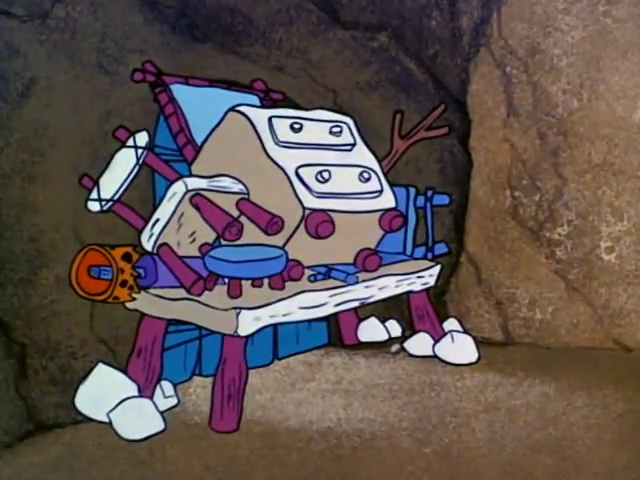

In [597]:
display_image(still_to_inspect)

In [623]:
incons_empty_frames = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['self_inconsistent_empty_frame']]).value_counts()

In [628]:
disagree_empty_frame = pd.Series([list(wrk.keys())[0] for wrk in worker_flaws['disagree_on_empty']]).value_counts()

In [636]:
set(incons_empty_frames.index).intersection(set(disagree_empty_frame.index))

{'A15DOG6AXQ7LGY',
 'A1QP6651C4Q8NS',
 'A1VOZRZINYXSIE',
 'A1YPX4OBE2YR2V',
 'A241K3CXIR4129',
 'A2NVXYZX2IEYVJ',
 'A2PU4YNWITAQVL',
 'A2QG1N2LFV0VXW',
 'A3FJQ2DZJIENKU',
 'A3R6KO03P9QLNO',
 'A3UPV16IECELHV',
 'AA9N1MNC5OBN8',
 'ACIZS6S5OQKQ6',
 'ASLY4WV7FCUDE'}

In [630]:
disagree_empty_frame

A3R6KO03P9QLNO    36
A2PU4YNWITAQVL    13
A2QG1N2LFV0VXW    13
A1IOMFFEKCWOIT    12
A2NVXYZX2IEYVJ    10
A15DOG6AXQ7LGY     9
A1OFOVU6TCQ2K3     8
A3UPV16IECELHV     7
ASLY4WV7FCUDE      6
A3NMOHKHT2RJI      6
A11NUW5OVADGYU     5
A2W7A2CP6GMPL4     5
AVQND8233HQWK      5
A191V8LNTTLHSA     5
A3FJQ2DZJIENKU     4
A1QP6651C4Q8NS     3
A1VOZRZINYXSIE     3
AF1HT6VL272QZ      3
A1YPX4OBE2YR2V     1
ATUR98N8W23Q3      1
ACIZS6S5OQKQ6      1
A1X02IA7J49OOW     1
A1ZCYJOVB9YEOW     1
A2EWQ9FQPEI7S5     1
A2SWAEEQFN0UDU     1
ASKV5KO5CV616      1
A1FSA483BHOQMR     1
A21TJ70K831G8P     1
AA9N1MNC5OBN8      1
A2ICL29CB31UG2     1
A1CCJL4HJJY58M     1
A241K3CXIR4129     1
dtype: int64

## pd

In [760]:
char_df = pd.DataFrame(characters_present)
char_df['aid'] = char_df['still_id'].apply(lambda x: x.rsplit('_', 1)[0])
char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))
char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))
all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]

In [759]:
# sample_row = char_df[char_df['w_id'] == 'A3R6KO03P9QLNO']
# sample_row =  sample_row[sample_row['characters'].apply(lambda x: bool(x.intersection({'empty frame'})))].iloc[random.randint(0, 100)]
# print(sample_row['characters'])
# display_image(sample_row['still_id'])

In [761]:
grouped_by_still = char_df.groupby('still_id')
agg_df = grouped_by_still.aggregate(len)

agged_on_mode = grouped_by_still.agg(lambda x: st.mode(x))

In [762]:
consensus_results_df = agged_on_mode.reset_index()

consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])
consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())
not_main_df = char_df[char_df['still_id'].isin(not_main)]


all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]

all_agree_set = set(all_agree['still_id'].tolist())

count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

conflict_images = set(disagree['still_id'].tolist())

conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

In [490]:
consensus_results_df

,still_id,characters,h_id,w_id,aid,all_main,n_chars,count_mode,mode_count,all_agree,two_agree
0,s_01_e_01_shot_018843_018917_40.png,"([{fred, barney}], [3])","([3XEIP58NL1N8G4ZE62JIDGHFCFQZLM], [3])","([A1QP6651C4Q8NS], [1])","([s_01_e_01_shot_018843_018917], [3])","([True], [3])","([2], [3])",3,3,True,False
1,s_01_e_04_shot_002970_003044_40.png,"([{wilma}], [3])","([3JYPJ2TAYJ8S28NCXIIIR5AH5KWPFL], [3])","([A1GL3COCJAZNGO], [1])","([s_01_e_04_shot_002970_003044], [3])","([True], [3])","([1], [3])",3,3,True,False
2,s_01_e_04_shot_004510_004584_40.png,"([{wilma}], [2])","([39RRBHZ0AV1BC9B8K6LO0PFH3DSZV5], [3])","([A1HA4T6P2CM2WV], [1])","([s_01_e_04_shot_004510_004584], [3])","([True], [3])","([1], [3])",3,2,True,False
3,s_01_e_04_shot_004631_004705_40.png,"([{fred}], [3])","([386T3MLZLOVGZC958JXM2CSNA8880H], [3])","([A1IOMFFEKCWOIT], [1])","([s_01_e_04_shot_004631_004705], [3])","([True], [3])","([1], [3])",3,3,True,False
4,s_01_e_04_shot_008479_008553_40.png,"([{fred}], [3])","([3HXK2V1N4LF2O1I164DODD20VP52GB], [3])","([A241K3CXIR4129], [1])","([s_01_e_04_shot_008479_008553], [3])","([True], [3])","([1], [3])",3,3,True,False
5,s_01_e_04_shot_009370_009444_40.png,"([{fred, barney}], [3])","([3NKW03WTLN7FD6AMNK77VYMR5J9QWC], [3])","([A2PU4YNWITAQVL], [1])","([s_01_e_04_shot_009370_009444], [3])","([True], [3])","([2], [3])",3,3,True,False
6,s_01_e_04_shot_010846_010920_40.png,"([{fred}], [3])","([3K2CEDRACC1W0A800MVFR5VNROUTM2], [3])","([A38QG4RDPLLBNG], [1])","([s_01_e_04_shot_010846_010920], [3])","([True], [3])","([1], [3])",3,3,True,False
7,s_01_e_04_shot_012010_012084_40.png,"([{barney}], [3])","([37MQ8Z1JQFW2AS310AZUKD940LUY24], [3])","([A2PU4YNWITAQVL], [1])","([s_01_e_04_shot_012010_012084], [3])","([True], [3])","([1], [3])",3,3,True,False
8,s_01_e_04_shot_012593_012667_40.png,"([{fred, barney}], [2])","([3RDTX9JRTZ1UVSSZYAO9HNXL2SW795], [3])","([A2PU4YNWITAQVL], [1])","([s_01_e_04_shot_012593_012667], [3])","([True], [3])","([2], [3])",3,2,True,False
9,s_01_e_04_shot_013671_013745_40.png,"([{fred}], [3])","([3TCFMTM8HFO5KMSYOLSL6QYUT0N21C], [3])","([A2PU4YNWITAQVL], [1])","([s_01_e_04_shot_013671_013745], [3])","([True], [3])","([1], [3])",3,3,True,False


In [763]:
char_df['characters'] = char_df['characters'].apply(lambda x: list(x))
grouped_by_worker = char_df.groupby('w_id')

In [764]:
w_agged = grouped_by_worker['characters'].sum()

In [776]:
del_hit = 'A1D9FOXZ0UT0L2'

In [787]:
w_agged = w_agged[~w_agged.index.str.contains(del_hit)]

In [479]:
# unique_chars = w_agged.apply(lambda x: len(x) /len(set(x)))

In [789]:
empty_fraction = w_agged.apply(lambda x: len([char for char in x if char == 'empty frame'])/ len(x))

In [790]:
empty_workers = empty_fraction[empty_fraction.sort_values(ascending=False) > 0.2]

In [792]:
empty_workers.index.intersection(set(prolific_workers.index))

Index([], dtype='object')

In [793]:
all_chars = w_agged.apply(lambda x: len(x))

In [794]:
prolific_workers = all_chars[all_chars > 100]

In [795]:
suspect_workers = set(prolific_workers.index).intersection(set(empty_workers.index))

## empty_workers

In [796]:
suspect_workers

{'A1RO22O88I71FD',
 'A26GVZEJLKZGSB',
 'A2NJTYYY37DNO',
 'A3R2HHQ128MHRS',
 'A3UPV16IECELHV'}

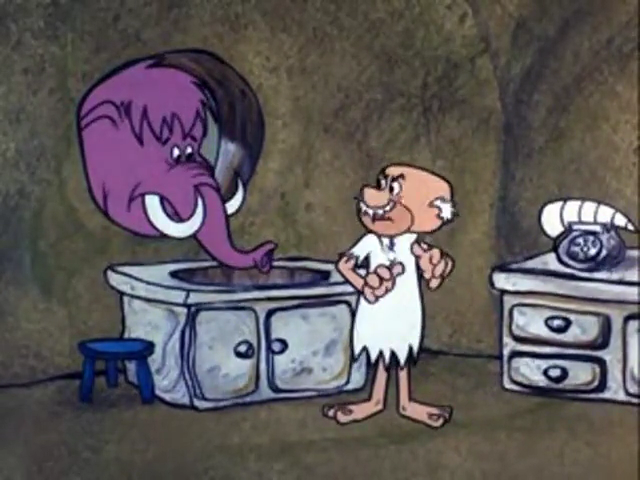

In [487]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

image_url = s3_base_path + 's_04_e_05_shot_015403_015477_40.png'
Image.open(requests.get(image_url, stream=True).raw)

In [488]:
char_df['characters'].apply(lambda x: [c for c in x if c != 'empty frame']).apply(lambda x: len(x)).mean()

1.3889229511547108

In [489]:
1632 * (1 + 1.38)

3884.16

In [305]:
# char_df[char_df['w_id'].isin(suspect_workers)][400:]

In [222]:
mono_worker = unique_chars[unique_chars < 5]

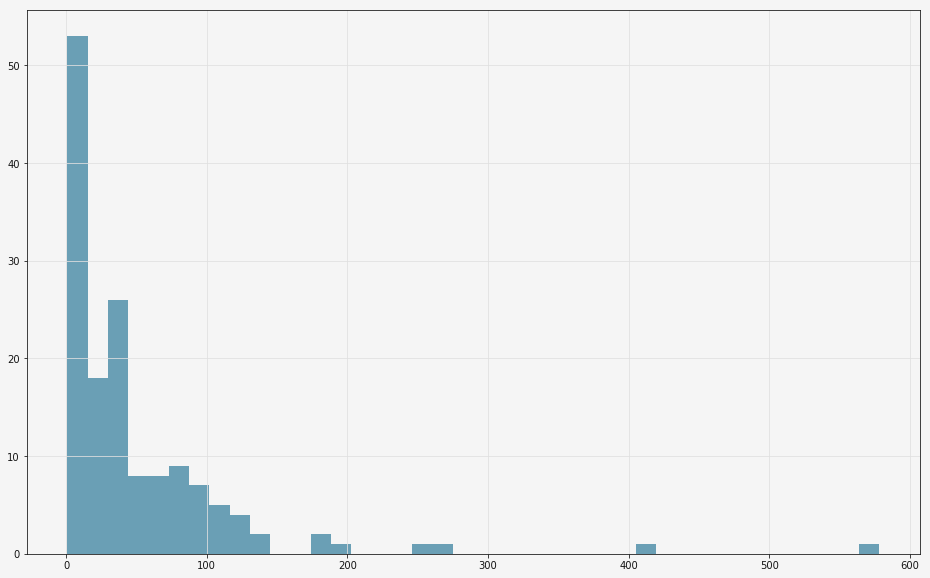

In [211]:
_ = all_chars.hist(bins=40)

In [154]:
consensus_results_df[consensus_results_df['two_agree']]

,still_id,characters,h_id,w_id,aid,all_main,n_chars,count_mode,mode_count,all_agree,two_agree
34,s_01_e_06_shot_021230_021304_40.png,"([{man with scarf and cap, man with blue glass...","([3NQUW096N78TADH124PJ0SFMXC29LH], [3])","([A1CUIN1FSZCM50], [1])","([s_01_e_06_shot_021230_021304], [3])","([False], [2])","([2], [2])",2,1,False,True
35,s_01_e_06_shot_023265_023339_40.png,"([{fred}], [1])","([3D17ECOUOFVU54OHSL6QP03MZEM31N], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_06_shot_023265_023339], [3])","([False], [2])","([2], [2])",2,1,False,True
41,s_01_e_07_shot_007742_007816_40.png,"([{barney}], [1])","([307L9TDWJZSXJBV6X84OM7GP2FS3NW], [3])","([A1J8Y204VZNWQW], [1])","([s_01_e_07_shot_007742_007816], [3])","([False], [2])","([1], [2])",2,1,False,True
52,s_01_e_13_shot_014034_014108_40.png,"([{fred}], [1])","([3MGHRFQY2MPVEI0NLNVG1PGP3NBY0L], [3])","([A11NUW5OVADGYU], [1])","([s_01_e_13_shot_014034_014108], [3])","([True], [3])","([1], [2])",2,1,False,True
55,s_01_e_13_shot_028290_028364_40.png,"([{betty, wilma}], [1])","([37NXA7GVSU6R7KU455UFSA4JO4KVLI], [3])","([A26699AEVYMM7N], [1])","([s_01_e_13_shot_028290_028364], [3])","([False], [2])","([3], [2])",2,1,False,True
60,s_01_e_14_shot_014144_014218_40.png,"([{fred, wilma}], [2])","([3CMV9YRYP41IGPUAOGGWPMTPTHCJLK], [3])","([A1OFOVU6TCQ2K3], [1])","([s_01_e_14_shot_014144_014218], [3])","([True], [3])","([2], [2])",2,2,False,True
62,s_01_e_14_shot_024354_024428_40.png,"([{fred}], [1])","([32CAVSKPCFPE4Y10752RC9TMCR5U1L], [2])","([A2QG1N2LFV0VXW], [1])","([s_01_e_14_shot_024354_024428], [2])","([True], [2])","([1], [2])",2,1,False,True
65,s_01_e_16_shot_006532_006606_40.png,"([{wilma}], [2])","([3MQY1YVHS4K6XKAQQILAC2B3FCD2BU], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_006532_006606], [3])","([True], [2])","([1], [2])",2,2,False,True
66,s_01_e_16_shot_013486_013560_40.png,"([{fred, barney}], [2])","([3XBYQ44Z6Q4S5M2E4O1203XEPQ8TWT], [3])","([A1CXAIALV3056P], [1])","([s_01_e_16_shot_013486_013560], [3])","([True], [3])","([2], [2])",2,2,False,True
70,s_01_e_16_shot_025041_025115_40.png,"([{fred, barney}], [2])","([3RWO3EJELI91CTT4QJ3X236N4AE1PX], [2])","([A1HA4T6P2CM2WV], [1])","([s_01_e_16_shot_025041_025115], [2])","([True], [2])","([2], [2])",2,2,False,True


In [138]:
600 * 3 * 3

5400

In [139]:
char_df.shape[0] * 0.05

243.4

In [140]:
char_counts = pd.Series(all_chars).value_counts()

In [141]:
char_counts

fred                                                            2326
barney                                                          1243
wilma                                                           1049
empty frame                                                      645
betty                                                            594
dino                                                             190
pebbles                                                          162
mr slate                                                         136
bamm bamm                                                         55
old man                                                           24
hoppy                                                             23
baby puss                                                         19
man with bow tie                                                  15
a man                                                             12
construction worker               

In [142]:
char_counts[char_counts < 16].sum()

932

In [143]:
char_df['empty'] = ~char_df['characters'].apply(lambda x:bool(x.difference(set(empty_characters))))

In [144]:
char_df['nonmain_characters'] = char_df['characters'].apply(lambda x: len(x.difference(set(main_characters))))

In [145]:
grouped_by_aid = char_df.groupby('aid')

In [146]:
grouped_by_aid.agg(max)['nonmain_characters'].sum()

708

In [147]:
grouped_by_aid.agg(max).shape

(1632, 8)

In [148]:
grouped_by_aid.agg(max)['nonmain_characters'].sum() * 3 * 3  * 0.02

127.44

In [150]:
# grouped_by_aid.agg(max)[grouped_by_aid.agg(min)['empty'] == True]

In [151]:
grouped_by_aid.agg(min)['empty'].sum()

73

In [152]:
grouped_by_aid.agg(max).shape

(1632, 8)

# create subtask data

In [14]:
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import cluster_from_nms

In [443]:
len(annotations_by_frame)

1632

In [424]:
with open('./complete_subtask_clips.txt', 'r') as f:
    clips_completed_raw = f.read()

clips_completed = set(clips_completed_raw.split())

In [425]:
len(clips_completed)

2286

In [18]:
len(clips_completed.intersection(set(list(annotations_by_frame.keys())[200:])))

0

In [450]:
annotations_by_frame['s_01_e_01_shot_018843_018917']

[{'characterBoxes': '[{"left":232,"top":6,"width":285,"height":350,"label":"barney"},{"left":138,"top":154,"width":231,"height":231,"label":"fred"}]',
  'h_id': '3XEIP58NL1N8G4ZE62JIDGHFCFQZLM',
  'stillID': 's_01_e_01_shot_018843_018917_40.png',
  'worker_id': 'A308VDNYF180ZF'},
 {'characterBoxes': '[{"left":196,"top":97,"width":120,"height":299,"label":"fred"},{"left":334,"top":0,"width":157,"height":346,"label":"barney"}]',
  'h_id': '3XEIP58NL1N8G4ZE62JIDGHFCFQZLM',
  'stillID': 's_01_e_01_shot_018843_018917_40.png',
  'worker_id': 'A1QP6651C4Q8NS'},
 {'characterBoxes': '[{"left":138,"top":165,"width":487,"height":289,"label":"fred"},{"left":249,"top":1,"width":279,"height":282,"label":"barney"}]',
  'h_id': '3XEIP58NL1N8G4ZE62JIDGHFCFQZLM',
  'stillID': 's_01_e_01_shot_018843_018917_40.png',
  'worker_id': 'A2R65L9397776L'}]

In [466]:
subtask_stills = {}
for aid, animation_annos in tqdm(list(annotations_by_frame.items())):
    try:
        two_frame_img, char_crops = create_subtask_data(animation_annos, cluster_from_nms)
        if char_crops:
            two_frame_img.save('./subtask_data/frames/' + aid + '_taskb.png')
            n_chars = len([char_image.save('./subtask_data/char_crops/' + aid + '_char_' + str(charn) +'_taskb.png') for charn, char_image in enumerate(char_crops)])
            subtask_stills[aid + '_taskb.png'] = n_chars
    except:
        print(aid)

100%|██████████| 1632/1632 [11:30<00:00,  2.36it/s]


In [467]:
pickle_this(subtask_stills, 'subtask_stills_to_anno_2.pkl')

# bounding box clustering

In [61]:
rev_dir = 'review_results'
img_dir = 'review_frames'

In [62]:
len(annotations_by_frame)

1632

In [79]:
# review_seq = {}
# error_frames = []
# for aid, animation_annos in tqdm(list(annotations_by_frame.items())[:5]):
#     try:
#         three_frame_img, consensus_boxes, labels = draw_animation_seq(animation_annos, cluster_from_nms)
#         avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
#         possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#         chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#         review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}
#         img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
#         three_frame_img.save(img_path)
#     except:
#         error_frames.append(aid)

# rev_page = generate_review_page('bbox_review_new_8_11_small.html')

In [121]:
review_seq = []
error_frames = []
for aid, animation_annos in tqdm(list(annotations_by_frame.items())[50:100]):
    single_frame_image, consensus_boxes, labels = draw_image_and_labels(animation_annos, cluster_from_nms)
    img_path = os.path.join(rev_dir, img_dir, aid) + '_rev.png'
    single_frame_image.save(img_path)
    review_seq.append(aid)
#     avg_votes = np.mean([box['votes'] for frame in consensus_boxes for box in frame])
#     possible_labels = [c['possible_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#     chosen_labels = [c['chosen_labels'] for c in sorted(labels, key=lambda x: x['box'][0])]
#     review_seq[aid] = {'votes': avg_votes, 'possible_labels': possible_labels, 'chosen_labels': chosen_labels}

#     except:
#         error_frames.append(aid)

rev_page = generate_single_image_review_page(review_seq, 'bbox_review_new_8_11_small.html')

100%|██████████| 50/50 [00:08<00:00,  5.22it/s]


In [122]:
annotations_by_frame['s_01_e_16_shot_033187_033261']

[{'characterBoxes': '[{"left":262,"top":16,"width":105,"height":115,"label":"empty frame"}]',
  'h_id': '372AGES0I55UE7UCA4ST27A3A7GXRC',
  'stillID': 's_01_e_16_shot_033187_033261_40.png',
  'worker_id': 'A2W7A2CP6GMPL4'},
 {'characterBoxes': '[{"left":223,"top":156,"width":96,"height":324,"label":"wilma"}]',
  'h_id': '372AGES0I55UE7UCA4ST27A3A7GXRC',
  'stillID': 's_01_e_16_shot_033187_033261_40.png',
  'worker_id': 'A15DOG6AXQ7LGY'},
 {'characterBoxes': '[{"left":25,"top":24,"width":598,"height":456,"label":"theves"}]',
  'h_id': '372AGES0I55UE7UCA4ST27A3A7GXRC',
  'stillID': 's_01_e_16_shot_033187_033261_40.png',
  'worker_id': 'ASKV5KO5CV616'}]

# bonus cost estimate

In [124]:
main_characters = [
    "Fred",
    "Wilma",
    "Mr Slate",
    "Barney",
    "Betty",
    "Pebbles",
    "Dino",
    "Baby Puss",
    "Hoppy",
    "Bamm Bamm",
]

empty_characters = ['no characters', 'empty frame']
main_characters += empty_characters
main_characters = [char.lower() for char in main_characters]

In [183]:
frame_cost = 0
bonus_cost = 0
for anno in list(review_seq.values()):
    frame_cost += 0.05 * 3
#     print(anno)
    bonus_cost += len([char for char in anno['chosen_labels'] if char not in main_characters]) * 0.03

In [184]:
print(frame_cost, bonus_cost)
frame_cost + bonus_cost

80.25000000000018 3.659999999999995


83.91000000000018

In [200]:
frame_count = []
for anno in list(review_seq.values()):
    frame_count += len([char for char in anno['chosen_labels'] if char not in empty_characters])

In [201]:
frame_count

787

# HTML Review

In [83]:
review_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h3>score: {{clip[2]}}      rank: {{clip[3]}}</h3>
        <p>{{clip[1]}}</p>
        <p>{{clip[4]}}</p>
        <p>{{clip[5]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_single_frame_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <p>{{clip[1]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

review_subtask_comp = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        {% for clip in clips %}
        <h2>clip: {{clip[0]}}</h2>
        <h4>original 3 frames:</h4>
        <p>{{clip[1]}}</p>
        <h4>new frames + original middle:</h4>
        <p>{{clip[2]}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [112]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'


def make_uri(clip_id, s3_base='review_frames/', file_ext='_rev.png'):
    s3_uri = s3_base + clip_id + file_ext
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag

def make_comp_uri(clip_id, s3_base=s3_base_path):
    s3_uri = s3_base + clip_id
    image_tag = '<img src="' + s3_uri +'" width=800px>'
    return image_tag


def generate_review_page(out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img[0]) for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    sorted_clip_ids = [img[0] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    votes = [img[1]['votes'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    chosen_labels = [img[1]['chosen_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    possible_labels = [img[1]['possible_labels'] for img in sorted(review_seq.items(), key=lambda x: x[1]['votes'])]
    
    send_to_template = zip(sorted_clip_ids, images_sorted_by_conf, votes, range(1, len(votes) + 1)[::-1], chosen_labels, possible_labels)
    env = Environment()
    template =  j2env.from_string(review_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_single_image_review_page(rev_seq, out_page='bbox_review.html'):
    images_sorted_by_conf = [make_uri(img) for img in rev_seq]
    send_to_template = zip(rev_seq, images_sorted_by_conf)
    env = Environment()
    template =  j2env.from_string(review_single_frame_page_html)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = send_to_template)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
    return page_html

def generate_subtask_review(rev_seq, out_page='review_subtask_comp.html'):
    env = Environment()
    rev_seq = [(rev[0], make_comp_uri(rev[1]), make_comp_uri(rev[2])) for rev in rev_seq]
    template =  j2env.from_string(review_subtask_comp)
    html_dir = './review_results/' 
    html_out_file = os.path.join(html_dir, out_page)
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    page_html =  template.render(clips = rev_seq)
    
    with open(html_out_file, 'w') as f:
        f.write(page_html.encode('ascii', 'ignore').decode('utf-8'))
        
    return page_html

In [71]:
# page_html = generate_subtask_review(subtask_rev_seq)

# hide

In [ ]:
vote_series = pd.Series([vote for vote in review_seq.values()])

In [13]:
# assignments =[]
# for assignment_triple in list(results.values()):
#     assignments.extend(assignment_triple)

# assignment_results = [create_result(ar) for ar in assignments]

# characters_present = [{'h_id': anno['h_id'], 'w_id': anno['worker_id'], 'still_id': anno['stillID'], 'characters': set([ch['label'] for ch in json.loads(anno['characterBoxes'])])} for anno in assignment_results]

# main_characters =  {"fred",
#              "barney",
#               "wilma",
#               "betty",
#               "pebbles",
#               "bamm bamm",
#               "dino",
#               "mr slate",
#               "baby puss",
#               "hoppy",
#               "no characters"}

# def all_main(char_set, main_chars=main_characters):
#     return not bool(char_set.difference(main_chars))

# char_df = pd.DataFrame(characters_present)

# char_df['all_main'] = char_df['characters'].apply(lambda x: all_main(x))

# all_chars = [c for char_list in char_df['characters'].apply(lambda x: list(x)).tolist() for c in char_list]
# char_counts = pd.Series(all_chars).value_counts()

# # char_counts.hist(bins = 30, log=True)

# char_df['n_chars'] = char_df['characters'].apply(lambda x: len(x))

# prolific_workers = char_df['w_id'].value_counts().index.tolist()[:5]

# grouped_by_still = char_df.groupby('still_id')

# agg_df = grouped_by_still.aggregate(len)

# import scipy

# agged_on_mode = grouped_by_still.agg(lambda x: scipy.stats.mode(x))
# consensus_results_df = agged_on_mode.reset_index()

# consensus_results_df['count_mode'] = consensus_results_df['n_chars'].apply(lambda x: x[1][0])

# consensus_results_df

# consensus_results_df['mode_count'] = consensus_results_df['characters'].apply(lambda x: x[1][0])

# consensus_results_df['all_agree'] = consensus_results_df['count_mode'] == 3
# consensus_results_df['two_agree'] = consensus_results_df['count_mode'] == 2

In [87]:
# all_main_annotations_by_frame = {}
# no_main_annotations_by_frame = {}
# mixed_all_frames = {}


# for aid, annos in annotations_by_frame.items():
#     still_ids = [still['stillID'] for still in annos]
#     annos = [anno for anno in annos]
#     if len([sid for sid in still_ids if sid in all_agree_set]) == 9:
#         all_main_annotations_by_frame[aid] = annos
#     elif len([sid for sid in still_ids if sid in not_main]) == 9:
#         no_main_annotations_by_frame[aid] = annos
#     else: 
#         mixed_all_frames[aid] = annos

# print(len(all_main_annotations_by_frame), len(no_main_annotations_by_frame), len(mixed_all_frames))

In [ ]:
# char_count_df = consensus_results_df[consensus_results_df['count_mode'] == 3]

# # consensus_results_df[agree_all_main]['characters'].apply(lambda x: x[1][0]).value_counts()

# not_main =set(consensus_results_df[~agree_all_main]['still_id'].tolist())

# not_main_df = char_df[char_df['still_id'].isin(not_main)]

# consensus_results_df.head(1)

# agree_all_main = consensus_results_df['all_main'].apply(lambda x: x[1][0]) == 3 

# all_agree = consensus_results_df[agree_all_main][consensus_results_df[agree_all_main]['all_agree']]
# disagree = consensus_results_df[agree_all_main][~consensus_results_df[agree_all_main]['all_agree']]







# all_agree_set = set(all_agree['still_id'].tolist())

# count_all_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 3]['still_id'].tolist())
# count_two_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 2]['still_id'].tolist())
# count_none_agree_set = set(consensus_results_df[consensus_results_df['count_mode'] == 1]['still_id'].tolist())

# conflict_images = set(disagree['still_id'].tolist())

# conflict_df = char_df[char_df['still_id'].isin(conflict_images)]

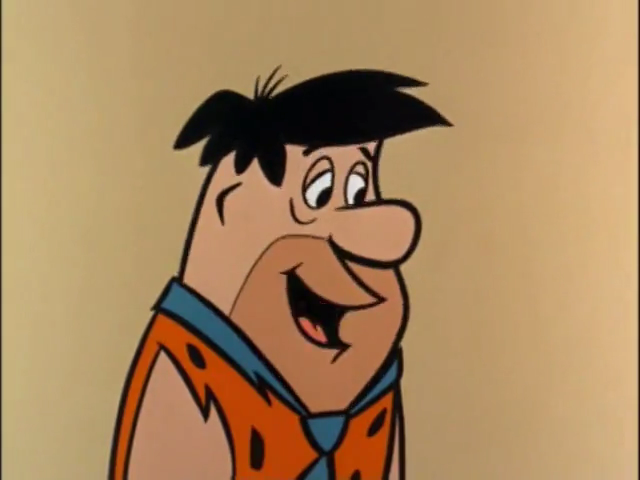

In [465]:
import PIL.Image as Image
import requests

image_n = 10


s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

image_url = s3_base_path + 's_01_e_04_shot_012010_012084_70.png'
Image.open(requests.get(image_url, stream=True).raw)